In [3]:
import paddle
from paddle.vision.transforms import Normalize

transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 加载 MNIST 训练集和测试集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

# 模型组网，构建并初始化一个模型 mnist
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(1, -1),
    paddle.nn.Linear(784, 512),
    paddle.nn.ReLU(),
    paddle.nn.Dropout(0.2),
    paddle.nn.Linear(512, 10)
)


In [10]:
class MyDataset(paddle.io.Dataset):
    def __init__(self,dataset):
        super(MyDataset,self).__init__()
        self.dataset=dataset
    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)//5

self_train_dataset=MyDataset(train_dataset)
self_test_dataset=MyDataset(test_dataset)



In [8]:
# 封装模型为一个 model 实例，便于进行后续的训练、评估和推理
model = paddle.Model(mnist)
# 为模型训练做准备，设置优化器及其学习率，并将网络的参数传入优化器，设置损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()),
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())


In [11]:
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(self_train_dataset,eval_data=self_test_dataset,
          epochs=5,
          batch_size=64,
          verbose=1)


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step 188/188 [==============================] - loss: 0.3066 - acc: 0.8209 - 10ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 32/32 [==============================] - loss: 0.2979 - acc: 0.8610 - 8ms/step          
Eval samples: 2000
Epoch 2/5
step 188/188 [==============================] - loss: 0.2239 - acc: 0.9100 - 9ms/step           
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 32/32 [==============================] - loss: 0.2277 - acc: 0.9005 - 7ms/step          
Eval samples: 2000
Epoch 3/5
step 188/188 [==============================] - loss: 0.1078 - acc: 0.9326 - 7ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the avera

In [12]:
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(self_test_dataset, verbose=1)
print(eval_result)


Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 10000/10000 [==============================] - loss: 6.6757e-06 - acc: 0.9398 - 3ms/step          
Eval samples: 10000
{'loss': [6.675698e-06], 'acc': 0.9398}


# predict输出
模型是单一输出：结果为[1,n批，m种类数],[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n)]，
模型是多输出：结果为[m,n],[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), (numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), …]

如果模型是单一输出，则输出的形状为 [1, n]，n 表示数据集的样本数。其中每个 numpy_ndarray_n 是对应原始数据经过模型计算后得到的预测结果，类型为 numpy 数组，例如 mnist 分类任务中，每个 numpy_ndarray_n 是长度为 10 的 numpy 数组。

如果模型是多输出，则输出的形状为[m, n]，m 表示标签的种类数，在多标签分类任务中，m 会根据标签的数目而定。

In [22]:
test_result=model.predict(self_test_dataset)
print(len(test_result)) #1
print(len(test_result[0]))#2000
print(test_result[0][0])

Predict begin...
step 2000/2000 [==============================] - 3ms/step          
Predict samples: 2000
1
2000
[[-2.6724722 -3.3764327  1.6130106  4.3637486 -6.9111414 -0.8649532
  -8.738144  10.380799  -0.8362608  1.0366589]]


In [17]:
pred_label=test_result[0][20].argmax()
img,true_label=self_test_dataset[20]
print(f'pred_label:{pred_label} true_label：{true_label}')

pred_label:9 true_label：[9]


(1, 28, 28)


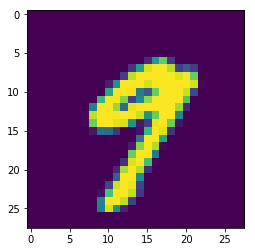

In [21]:
print(img.shape)
from matplotlib import pyplot as plt
plt.imshow(img[0])

# fit拆解
飞桨框架通过基础 API 对模型进行训练，对应高层 API 的 Model.prepare 与 Model.fit ，一般包括如下几个步骤：

加载训练数据集、声明模型、设置模型实例为 train 模式

设置优化器、损失函数与各个超参数

设置模型训练的二层循环嵌套，并在内层循环嵌套中设置如下内容

3.1 从数据读取器 DataLoader 获取一批次训练数据

3.2 执行一次预测，即经过模型计算获得输入数据的预测值

3.3 计算预测值与数据集标签的损失

3.4 计算预测值与数据集标签的准确率

3.5 将损失进行反向传播

3.6 打印模型的轮数、批次、损失值、准确率等信息

3.7 执行一次优化器步骤，即按照选择的优化算法，根据当前批次数据的梯度更新传入优化器的参数

3.8 将优化器的梯度进行清零

epoch: 0, batch_id: 50, loss is: [0.04622211], acc is: [0.96875]
epoch: 0, batch_id: 100, loss is: [0.04025707], acc is: [0.984375]
epoch: 0, batch_id: 150, loss is: [0.01878752], acc is: [1.]
epoch: 1, batch_id: 50, loss is: [0.04404696], acc is: [0.984375]
epoch: 1, batch_id: 100, loss is: [0.00445972], acc is: [1.]
epoch: 1, batch_id: 150, loss is: [0.0383167], acc is: [0.96875]
epoch: 2, batch_id: 50, loss is: [0.00124187], acc is: [1.]
epoch: 2, batch_id: 100, loss is: [0.00665052], acc is: [1.]
epoch: 2, batch_id: 150, loss is: [0.01051711], acc is: [1.]
epoch: 3, batch_id: 50, loss is: [0.00524316], acc is: [1.]
epoch: 3, batch_id: 100, loss is: [0.06856215], acc is: [0.96875]
epoch: 3, batch_id: 150, loss is: [0.03784144], acc is: [0.984375]
epoch: 4, batch_id: 50, loss is: [0.04834902], acc is: [0.96875]
epoch: 4, batch_id: 100, loss is: [0.02801925], acc is: [0.984375]
epoch: 4, batch_id: 150, loss is: [0.00773724], acc is: [1.]
